In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from scipy.stats import gaussian_kde
import sklearn
# if sklearn.__version__ < "1.5.1":
#     raise ImportError("Please update scikit-learn to version 1.5.1 or higher.")

In [22]:
class Plotter():
    def __init__(self, data_path):
        self.data_path = data_path
        self.PROTEIN_TYPES_NAMES = np.array([None, "Oxidoreductases", "Transferases", "Hydrolases", "Lyases", "Isomerases", "Ligases", "Translocases"])
        self.pca = dict()
        self.umap = dict()
        self.tsne = dict()
        self.data = None
    
    def load_data(self):
        self.data = joblib.load(self.data_path)
        return self

    def create_protein_id_and_label_availability(self):
        if 'protein_id' in self.data.columns and 'label' in self.data.columns:
            return self
        else:
            self.data["protein_id"] = [int(i.split(".")[0]) for i in self.data["ECNumber"]]
            self.data["protein_label"] = [
                f"{pid}_{self.PROTEIN_TYPES_NAMES[pid]}"
                for pid in self.data["protein_id"]
            ]
            return self

    def check_feature_availability(self, feature_name):
        if feature_name not in self.data.columns:
            raise ValueError(f"Feature '{feature_name}' not found in data.")
        return self
    
    def plot_pca_fit(self, feature_name="protein_features", n_components=0.95 ,*args, **kwargs):
        """Fit PCA and add PCA features to data"""
        if feature_name not in self.data.columns:
            raise ValueError(f"Feature '{feature_name}' not found in data.")
        
        self.pca[feature_name] = PCA(n_components=n_components)
        self.pca[feature_name].fit(np.vstack(self.data[feature_name].values))
        X_pca = self.pca[feature_name].transform(np.vstack(self.data[feature_name].values))
        self.data[f"PCA_{feature_name}"] = [x.tolist() for x in X_pca]
        if kwargs.get('save_path'):
            plt.savefig(kwargs['save_path'], dpi=1200)
        return self

    def plot_pca_variance(self, feature_name="protein_features", figsize=(12, 5),*args, **kwargs):
        """Plot PCA explained variance"""
        if feature_name not in self.pca:
            raise ValueError(f"PCA not fitted for {feature_name}. Run plot_pca_fit first.")
        
        explained_variance_ratio = self.pca[feature_name].explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)

        plt.figure(figsize=figsize)

        # Individual variance plot
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Individual Explained Variance by PC')
        plt.xticks(range(1, len(explained_variance_ratio) + 1))

        # Cumulative variance plot
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
        plt.xlabel('Principal Component')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('Cumulative Explained Variance')
        plt.xticks(range(1, len(cumulative_variance) + 1))
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        if kwargs.get('save_path'):
            plt.savefig(kwargs['save_path'], dpi=1200)
        plt.show()
        
        
        return self
    
    def plot_umap_fit(self, feature_name="protein_features", n_components=2, n_neighbors=15, min_dist=0.1, random_state=42, metric='euclidean'):
        """Fit UMAP and add UMAP features to data"""
        # Remove duplicates for fitting
        X_all = np.vstack(self.data[feature_name].values)
        unique_rows, unique_indices = np.unique(X_all, axis=0, return_index=True)
        unique_rows = unique_rows.astype(np.float32)
        unique_rows = np.nan_to_num(unique_rows, nan=0.0, posinf=1e6, neginf=-1e6)

        
        self.umap[feature_name] = UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=random_state,
            metric=metric
        )
        self.umap[feature_name].fit(unique_rows)
        X_umap = self.umap[feature_name].transform(X_all)
        self.data[f"UMAP_{feature_name}"] = [x.tolist() for x in X_umap]
        return self
    
    def plot_tsne_fit(self, feature_name="protein_features", n_components=2, perplexity=30, max_iter=1000, learning_rate=200, random_state=42):
        """Fit t-SNE and add t-SNE features to data"""
        X_all = np.vstack(self.data[feature_name].values)
        
        
        self.tsne[feature_name] = TSNE(
            n_components=n_components,
            perplexity=perplexity,
            max_iter=max_iter,
            learning_rate=learning_rate,
            random_state=random_state
        )
        X_tsne = self.tsne[feature_name].fit_transform(X_all)
        self.data[f"TSNE_{feature_name}"] = [x.tolist() for x in X_tsne]
        return self
    
    def plot_density_scatter(self, method="UMAP", feature_name="protein_features", color_by="protein_id", 
                           train_indices=None, test_indices=None, figsize=(14, 10), alpha=0.7, s=50, 
                           title=None, save_path=None, density_alpha=0.9, density_levels=50):
        """
        Plot density heatmap with scatter overlay
        
        Parameters:
        - method: "PCA", "UMAP", or "TSNE"
        - feature_name: name of the feature used for dimensionality reduction
        - color_by: column name to color the test points by
        - train_indices: indices of training data for density calculation
        - test_indices: indices of test data for scatter plot
        - other parameters: same as plot_scatter
        """
        method = method.upper()
        column_name = f"{method}_{feature_name}"
        
        if column_name not in self.data.columns:
            raise ValueError(f"{column_name} not found. Run plot_{method.lower()}_fit first.")
        
        if color_by not in self.data.columns:
            raise ValueError(f"Color column '{color_by}' not found in data.")
        
        # Use all data if indices not provided
        if train_indices is None:
            train_indices = self.data.index
        if test_indices is None:
            test_indices = self.data.index
        
        # Get training data for density calculation
        train_coords = np.array([coord for coord in self.data.loc[train_indices, column_name]])
        
        # Create grid for density calculation
        x_padding = (train_coords[:, 0].max() - train_coords[:, 0].min()) * 0.1
        y_padding = (train_coords[:, 1].max() - train_coords[:, 1].min()) * 0.1
        
        x_min, x_max = train_coords[:, 0].min() - x_padding, train_coords[:, 0].max() + x_padding
        y_min, y_max = train_coords[:, 1].min() - y_padding, train_coords[:, 1].max() + y_padding
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid_points = np.vstack([xx.ravel(), yy.ravel()])
        
        # Calculate density
        kde = gaussian_kde(train_coords.T)
        density = kde(grid_points).reshape(xx.shape)
        
        # Plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Layer 1: density heatmap
        contour = ax.contourf(xx, yy, density, levels=density_levels, cmap='Blues', alpha=density_alpha)
        cbar1 = plt.colorbar(contour, ax=ax, shrink=0.8, aspect=20, pad=0.12)
        cbar1.set_label('Train Density', rotation=270, labelpad=15)
        
        # Layer 2: test points scatter
        test_coords = np.array([coord for coord in self.data.loc[test_indices, column_name]])
        color_data = self.data.loc[test_indices, color_by]
        
        # Handle different types of color columns
        if color_by == "protein_id":
            # Special handling for protein types
            from matplotlib.colors import ListedColormap
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
            cmap_7 = ListedColormap(colors)
            
            scatter = ax.scatter(test_coords[:, 0], test_coords[:, 1], c=color_data - 1, 
                               alpha=alpha, s=s, cmap=cmap_7, vmin=0, vmax=6, edgecolors='black', linewidth=0.5)
            cbar2 = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
            cbar2.set_label('Protein Type', rotation=270, labelpad=15)
            cbar2.set_ticks([i for i in range(7)])
            cbar2.set_ticklabels([self.PROTEIN_TYPES_NAMES[i] for i in range(1, 8)])
            
        elif pd.api.types.is_categorical_dtype(color_data) or color_data.dtype == 'object':
            # Handle categorical/string columns (e.g., "WT", "mutant")
            unique_categories = color_data.unique()
            n_categories = len(unique_categories)
            
            # Create a mapping from category to numeric value
            category_to_num = {cat: i for i, cat in enumerate(unique_categories)}
            numeric_data = color_data.map(category_to_num)
            
            # Choose appropriate colormap based on number of categories
            if n_categories <= 2:
                cmap_name = 'RdYlBu'
            elif n_categories <= 10:
                cmap_name = 'tab10'
            else:
                cmap_name = 'viridis'
            
            scatter = ax.scatter(test_coords[:, 0], test_coords[:, 1], c=numeric_data, 
                               alpha=alpha, s=s, cmap=cmap_name, 
                               vmin=0, vmax=n_categories-1, edgecolors='black', linewidth=0.5)
            
            cbar2 = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
            cbar2.set_label(color_by, rotation=270, labelpad=15)
            
            # Set categorical labels on colorbar
            if n_categories <= 10:  # Only show labels if not too many categories
                cbar2.set_ticks([i for i in range(n_categories)])
                cbar2.set_ticklabels(unique_categories)
        else:
            # Handle numeric columns
            scatter = ax.scatter(test_coords[:, 0], test_coords[:, 1], c=color_data, 
                               alpha=alpha, s=s, cmap='Reds', edgecolors='black', linewidth=0.5)
            cbar2 = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
            cbar2.set_label(color_by, rotation=270, labelpad=15)
        
        ax.set_xlabel(f'{method}1')
        ax.set_ylabel(f'{method}2')
        
        if title is None:
            title = f'Train Density with Test {method} Points Colored by {color_by}'
        ax.set_title(title)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=1200, bbox_inches='tight')
            
        plt.show()
        return self
    
    def plot_scatter(self, method="PCA", feature_name="protein_features", color_by="protein_id", figsize=(10, 8), alpha=0.6, s=50, title=None, save_path=None):
        """
        Plot scatter plot using PCA, UMAP, or t-SNE
        
        Parameters:
        - method: "PCA", "UMAP", or "TSNE"
        - feature_name: name of the feature used for dimensionality reduction
        - color_by: column name to color the points by
        - figsize: figure size
        - alpha: transparency of points
        - s: size of points
        - title: custom title for the plot
        - save_path: path to save the figure (optional)
        """
        method = method.upper()
        column_name = f"{method}_{feature_name}"
        
        if column_name not in self.data.columns:
            raise ValueError(f"{column_name} not found. Run plot_{method.lower()}_fit first.")
        
        if color_by not in self.data.columns:
            raise ValueError(f"Color column '{color_by}' not found in data.")
        
        plt.figure(figsize=figsize)
        
        # Extract coordinates
        coords = np.array([coord for coord in self.data[column_name]])
        x_values = coords[:, 0]
        y_values = coords[:, 1]
        
        # Handle different types of color columns
        color_data = self.data[color_by]
        
        if color_by == "protein_id":
            # Special handling for protein types
            from matplotlib.colors import ListedColormap
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
            cmap_7 = ListedColormap(colors)
            
            scatter = plt.scatter(x_values, y_values, c=color_data - 1, alpha=alpha, s=s, 
                                cmap=cmap_7, vmin=0, vmax=6)
            
            # Add colorbar with protein type labels
            cbar = plt.colorbar(scatter)
            cbar.set_label('Protein Type', rotation=270, labelpad=15)
            cbar.set_ticks([i for i in range(7)])
            cbar.set_ticklabels([self.PROTEIN_TYPES_NAMES[i] for i in range(1, 8)])
            
        elif pd.api.types.is_categorical_dtype(color_data) or color_data.dtype == 'object':
            # Handle categorical/string columns (e.g., "WT", "mutant")
            unique_categories = color_data.unique()
            n_categories = len(unique_categories)
            
            # Create a mapping from category to numeric value
            category_to_num = {cat: i for i, cat in enumerate(unique_categories)}
            numeric_data = color_data.map(category_to_num)
            
            # Choose appropriate colormap based on number of categories
            if n_categories <= 2:
                cmap_name = 'RdYlBu'
            elif n_categories <= 10:
                cmap_name = 'tab10'
            else:
                cmap_name = 'viridis'
            
            scatter = plt.scatter(x_values, y_values, c=numeric_data, alpha=alpha, s=s, 
                                cmap=cmap_name, vmin=0, vmax=n_categories-1)
            
            cbar = plt.colorbar(scatter)
            cbar.set_label(color_by, rotation=270, labelpad=15)
            
            # Set categorical labels on colorbar
            if n_categories <= 10:  # Only show labels if not too many categories
                cbar.set_ticks([i for i in range(n_categories)])
                cbar.set_ticklabels(unique_categories)
        else:
            # General handling for numeric columns
            scatter = plt.scatter(x_values, y_values, c=color_data, alpha=alpha, s=s, cmap='viridis')
            cbar = plt.colorbar(scatter)
            cbar.set_label(color_by, rotation=270, labelpad=15)
        
        plt.xlabel(f'{method}1')
        plt.ylabel(f'{method}2')
        
        if title is None:
            title = f'{method} Plot Colored by {color_by}'
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=1200, bbox_inches='tight')
            
        plt.show()
        return self
    
    def plot_density_scatter(self, method="UMAP", feature_name="protein_features", color_by="protein_id", 
                           train_indices=None, test_indices=None, figsize=(14, 10), alpha=0.7, s=50, 
                           title=None, save_path=None, density_alpha=0.9, density_levels=50):
        """
        Plot density heatmap with scatter overlay
        
        Parameters:
        - method: "PCA", "UMAP", or "TSNE"
        - feature_name: name of the feature used for dimensionality reduction
        - color_by: column name to color the test points by
        - train_indices: indices of training data for density calculation
        - test_indices: indices of test data for scatter plot
        - other parameters: same as plot_scatter
        """
        method = method.upper()
        column_name = f"{method}_{feature_name}"
        
        if column_name not in self.data.columns:
            raise ValueError(f"{column_name} not found. Run plot_{method.lower()}_fit first.")
        
        if color_by not in self.data.columns:
            raise ValueError(f"Color column '{color_by}' not found in data.")
        
        # Use all data if indices not provided
        if train_indices is None:
            train_indices = self.data.index
        if test_indices is None:
            test_indices = self.data.index
        
        # Get training data for density calculation
        train_coords = np.array([coord for coord in self.data.loc[train_indices, column_name]])
        
        # Create grid for density calculation
        x_padding = (train_coords[:, 0].max() - train_coords[:, 0].min()) * 0.1
        y_padding = (train_coords[:, 1].max() - train_coords[:, 1].min()) * 0.1
        
        x_min, x_max = train_coords[:, 0].min() - x_padding, train_coords[:, 0].max() + x_padding
        y_min, y_max = train_coords[:, 1].min() - y_padding, train_coords[:, 1].max() + y_padding
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid_points = np.vstack([xx.ravel(), yy.ravel()])
        
        # Calculate density
        kde = gaussian_kde(train_coords.T)
        density = kde(grid_points).reshape(xx.shape)
        
        # Plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Layer 1: density heatmap
        contour = ax.contourf(xx, yy, density, levels=density_levels, cmap='Blues', alpha=density_alpha)
        cbar1 = plt.colorbar(contour, ax=ax, shrink=0.8, aspect=20, pad=0.12)
        cbar1.set_label('Train Density', rotation=270, labelpad=15)
        
        # Layer 2: test points scatter
        test_coords = np.array([coord for coord in self.data.loc[test_indices, column_name]])
        color_data = self.data.loc[test_indices, color_by]
        
        # Handle different types of color columns
        if color_by == "protein_id":
            # Special handling for protein types
            from matplotlib.colors import ListedColormap
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
            cmap_7 = ListedColormap(colors)
            
            scatter = ax.scatter(test_coords[:, 0], test_coords[:, 1], c=color_data - 1, 
                               alpha=alpha, s=s, cmap=cmap_7, vmin=0, vmax=6, edgecolors='black', linewidth=0.5)
            cbar2 = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
            cbar2.set_label('Protein Type', rotation=270, labelpad=15)
            cbar2.set_ticks([i for i in range(7)])
            cbar2.set_ticklabels([self.PROTEIN_TYPES_NAMES[i] for i in range(1, 8)])
            
        elif pd.api.types.is_categorical_dtype(color_data) or color_data.dtype == 'object':
            # Handle categorical/string columns (e.g., "WT", "mutant")
            unique_categories = color_data.unique()
            n_categories = len(unique_categories)
            
            # Create a mapping from category to numeric value
            category_to_num = {cat: i for i, cat in enumerate(unique_categories)}
            numeric_data = color_data.map(category_to_num)
            
            # Choose appropriate colormap based on number of categories
            if n_categories <= 2:
                cmap_name = 'RdYlBu'
            elif n_categories <= 10:
                cmap_name = 'tab10'
            else:
                cmap_name = 'viridis'
            
            scatter = ax.scatter(test_coords[:, 0], test_coords[:, 1], c=numeric_data, 
                               alpha=alpha, s=s, cmap=cmap_name, 
                               vmin=0, vmax=n_categories-1, edgecolors='black', linewidth=0.5)
            
            cbar2 = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
            cbar2.set_label(color_by, rotation=270, labelpad=15)
            
            # Set categorical labels on colorbar
            if n_categories <= 10:  # Only show labels if not too many categories
                cbar2.set_ticks([i for i in range(n_categories)])
                cbar2.set_ticklabels(unique_categories)
        else:
            # Handle numeric columns
            scatter = ax.scatter(test_coords[:, 0], test_coords[:, 1], c=color_data, 
                               alpha=alpha, s=s, cmap='Reds', edgecolors='black', linewidth=0.5)
            cbar2 = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
            cbar2.set_label(color_by, rotation=270, labelpad=15)
        
        ax.set_xlabel(f'{method}1')
        ax.set_ylabel(f'{method}2')
        
        if title is None:
            title = f'Train Density with Test {method} Points Colored by {color_by}'
        ax.set_title(title)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=1200, bbox_inches='tight')
            
        plt.show()
        return self
    
    

In [23]:
kcat_plotter = Plotter(data_path="./../A01_dataset/kcat_data_with_features.joblib")
kcat_plotter.load_data().create_protein_id_and_label_availability()
kcat_plotter.check_feature_availability("metabolite_features").check_feature_availability("protein_features")
kcat_plotter.data

,ECNumber,organism,Substrate,Sequence,Smiles,value,type,source,metabolite_features,protein_features,label,protein_id,protein_label
0,1.1.1.1,Picrophilus torridus,ethanol,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,CCO,0.00086,wild,custom,"[1.1508174, 2.0531795, -0.729387, -2.5030358, ...","[-0.0042622425, -0.09458677, 0.15183483, 0.133...",-3.065501e+00,1,1_Oxidoreductases
1,1.1.1.1,Saccharolobus solfataricus,NAD+,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,0.52,mutant,custom,"[0.24613403, 0.28360432, -0.31403235, -0.48450...","[-0.030971242, -0.06459375, 0.24837981, 0.0344...",-2.839967e-01,1,1_Oxidoreductases
2,1.1.1.1,Saccharolobus solfataricus,(R)-2-pentanol,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,CCC[C@@H](C)O,1.1,wild,custom,"[0.8070318, 1.047707, 0.76315093, -1.3591596, ...","[-0.028735004, -0.061822645, 0.24906047, 0.032...",4.139269e-02,1,1_Oxidoreductases
3,1.1.1.1,Saccharolobus solfataricus,(R)-2-butanol,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,CC[C@@H](C)O,1.0,wild,custom,"[0.7685718, 1.093973, 0.7508034, -1.4337907, -...","[-0.028735004, -0.061822645, 0.24906047, 0.032...",4.342945e-10,1,1_Oxidoreductases
4,1.1.1.1,Saccharolobus solfataricus,3-Pentanol,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,COC(=O)C1=CN2CCc3c([nH]c4ccccc34)[C@@]2(C)[C@@...,1.5,wild,custom,"[0.4484269, 0.54636896, 0.19070227, -0.2610815...","[-0.028735004, -0.061822645, 0.24906047, 0.032...",1.760913e-01,1,1_Oxidoreductases
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35142,1.1.1.82,Zea mays,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...,955.0,wild,dlkcat,"[0.42666194, -0.46613595, -0.71941936, 0.09735...","[0.039386965, -0.045581497, 0.10150621, 0.1012...",2.980003e+00,1,1_Oxidoreductases
35143,1.1.1.82,Zea mays,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,O=C(O)CC(O)C(=O)O,2.9,wild,dlkcat,"[0.18948561, 0.033285808, 0.09464491, -0.81195...","[0.039386965, -0.045581497, 0.10150621, 0.1012...",4.623980e-01,1,1_Oxidoreductases
35144,1.1.1.82,Zea mays,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,2.9,wild,dlkcat,"[0.28133714, -0.5288892, -0.7426859, -0.012091...","[0.039386965, -0.045581497, 0.10150621, 0.1012...",4.623980e-01,1,1_Oxidoreductases
35145,1.1.1.82,Spinacia oleracea,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,O=C(O)CC(O)C(=O)O,6.7,wild,dlkcat,"[0.18948561, 0.033285808, 0.09464491, -0.81195...","[0.029217465, -0.08372672, 0.0883127, 0.147737...",8.260748e-01,1,1_Oxidoreductases


In [24]:
kcat_plotter.data

,ECNumber,organism,Substrate,Sequence,Smiles,value,type,source,metabolite_features,protein_features,label,protein_id,protein_label
0,1.1.1.1,Picrophilus torridus,ethanol,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,CCO,0.00086,wild,custom,"[1.1508174, 2.0531795, -0.729387, -2.5030358, ...","[-0.0042622425, -0.09458677, 0.15183483, 0.133...",-3.065501e+00,1,1_Oxidoreductases
1,1.1.1.1,Saccharolobus solfataricus,NAD+,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,0.52,mutant,custom,"[0.24613403, 0.28360432, -0.31403235, -0.48450...","[-0.030971242, -0.06459375, 0.24837981, 0.0344...",-2.839967e-01,1,1_Oxidoreductases
2,1.1.1.1,Saccharolobus solfataricus,(R)-2-pentanol,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,CCC[C@@H](C)O,1.1,wild,custom,"[0.8070318, 1.047707, 0.76315093, -1.3591596, ...","[-0.028735004, -0.061822645, 0.24906047, 0.032...",4.139269e-02,1,1_Oxidoreductases
3,1.1.1.1,Saccharolobus solfataricus,(R)-2-butanol,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,CC[C@@H](C)O,1.0,wild,custom,"[0.7685718, 1.093973, 0.7508034, -1.4337907, -...","[-0.028735004, -0.061822645, 0.24906047, 0.032...",4.342945e-10,1,1_Oxidoreductases
4,1.1.1.1,Saccharolobus solfataricus,3-Pentanol,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,COC(=O)C1=CN2CCc3c([nH]c4ccccc34)[C@@]2(C)[C@@...,1.5,wild,custom,"[0.4484269, 0.54636896, 0.19070227, -0.2610815...","[-0.028735004, -0.061822645, 0.24906047, 0.032...",1.760913e-01,1,1_Oxidoreductases
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35142,1.1.1.82,Zea mays,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...,955.0,wild,dlkcat,"[0.42666194, -0.46613595, -0.71941936, 0.09735...","[0.039386965, -0.045581497, 0.10150621, 0.1012...",2.980003e+00,1,1_Oxidoreductases
35143,1.1.1.82,Zea mays,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,O=C(O)CC(O)C(=O)O,2.9,wild,dlkcat,"[0.18948561, 0.033285808, 0.09464491, -0.81195...","[0.039386965, -0.045581497, 0.10150621, 0.1012...",4.623980e-01,1,1_Oxidoreductases
35144,1.1.1.82,Zea mays,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,2.9,wild,dlkcat,"[0.28133714, -0.5288892, -0.7426859, -0.012091...","[0.039386965, -0.045581497, 0.10150621, 0.1012...",4.623980e-01,1,1_Oxidoreductases
35145,1.1.1.82,Spinacia oleracea,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,O=C(O)CC(O)C(=O)O,6.7,wild,dlkcat,"[0.18948561, 0.033285808, 0.09464491, -0.81195...","[0.029217465, -0.08372672, 0.0883127, 0.147737...",8.260748e-01,1,1_Oxidoreductases


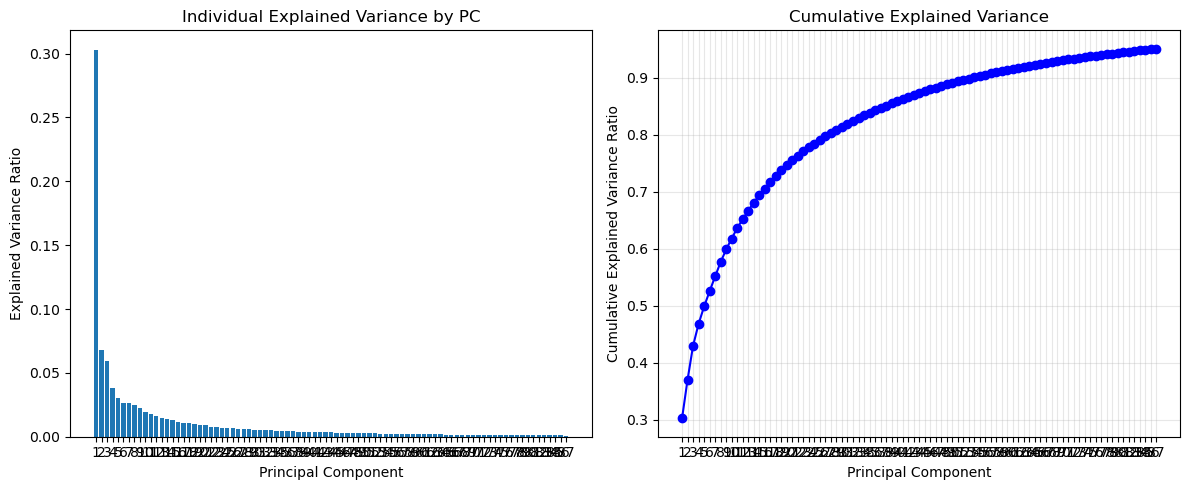

In [25]:
# Fit PCA for protein features
kcat_plotter.plot_pca_fit("protein_features").plot_pca_variance("protein_features",save_path="./../A04_result_plot/protein_features_pca_variance.svg")

In [26]:
kcat_plotter

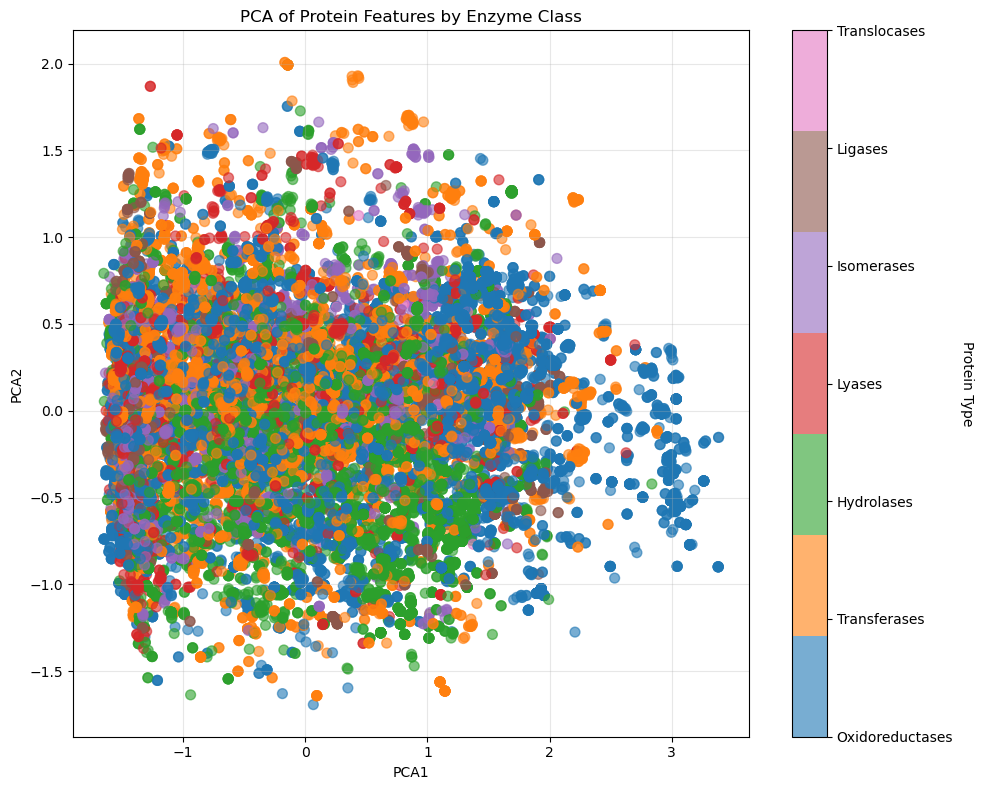

In [27]:
# Plot PCA colored by protein types
kcat_plotter.plot_scatter("PCA", "protein_features", "protein_id", title="PCA of Protein Features by Enzyme Class",save_path="./../A04_result_plot/protein_features_pca_scatter.svg")

In [7]:
# Fit t-SNE for protein features
kcat_plotter.plot_tsne_fit("protein_features", perplexity=30, learning_rate=200)

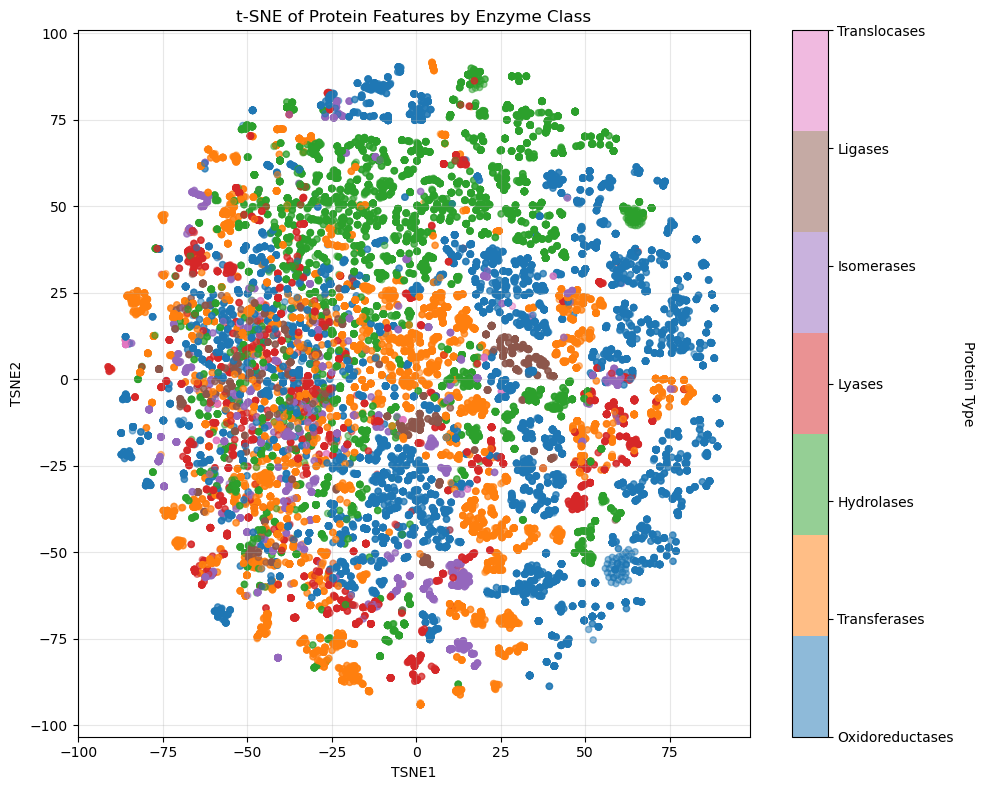

C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_27240\1250937729.py:269: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(color_data) or color_data.dtype == 'object':


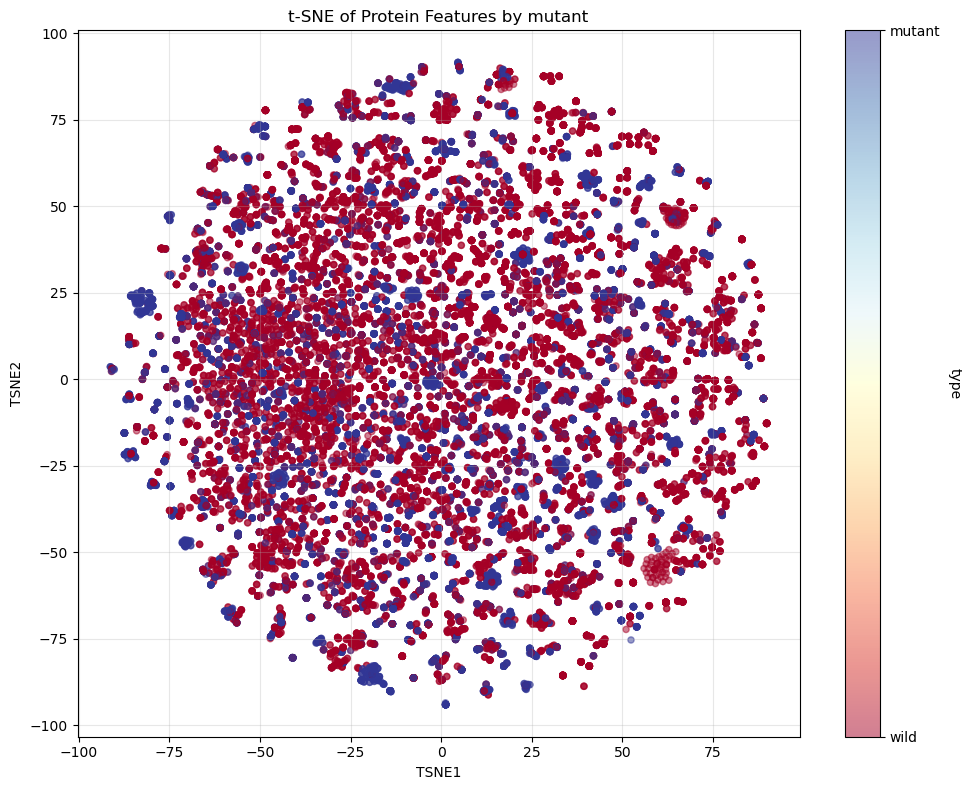

In [9]:
# Plot t-SNE colored by protein types
kcat_plotter.plot_scatter("TSNE", "protein_features", "protein_id", title="t-SNE of Protein Features by Enzyme Class",alpha=0.5, s=20, save_path="./../A04_result_plot/protein_features_tsne_scatter_by_protein_class.svg")
kcat_plotter.plot_scatter("TSNE", "protein_features", "type", title="t-SNE of Protein Features by mutant",alpha=0.5, s=20,save_path="./../A04_result_plot/protein_features_tsne_scatter_by_mutant.svg")

In [28]:
kcat_plotter.data["protein_features"]

0        [-0.0042622425, -0.09458677, 0.15183483, 0.133...
1        [-0.030971242, -0.06459375, 0.24837981, 0.0344...
2        [-0.028735004, -0.061822645, 0.24906047, 0.032...
3        [-0.028735004, -0.061822645, 0.24906047, 0.032...
4        [-0.028735004, -0.061822645, 0.24906047, 0.032...
                               ...                        
35142    [0.039386965, -0.045581497, 0.10150621, 0.1012...
35143    [0.039386965, -0.045581497, 0.10150621, 0.1012...
35144    [0.039386965, -0.045581497, 0.10150621, 0.1012...
35145    [0.029217465, -0.08372672, 0.0883127, 0.147737...
35146    [0.029217465, -0.08372672, 0.0883127, 0.147737...
Name: protein_features, Length: 35147, dtype: object

In [29]:
# Plot UMAP colored by protein types
kcat_plotter.plot_umap_fit("protein_features", n_neighbors=15, min_dist=0.1)
kcat_plotter.data["protein_features"]


0        [-0.0042622425, -0.09458677, 0.15183483, 0.133...
1        [-0.030971242, -0.06459375, 0.24837981, 0.0344...
2        [-0.028735004, -0.061822645, 0.24906047, 0.032...
3        [-0.028735004, -0.061822645, 0.24906047, 0.032...
4        [-0.028735004, -0.061822645, 0.24906047, 0.032...
                               ...                        
35142    [0.039386965, -0.045581497, 0.10150621, 0.1012...
35143    [0.039386965, -0.045581497, 0.10150621, 0.1012...
35144    [0.039386965, -0.045581497, 0.10150621, 0.1012...
35145    [0.029217465, -0.08372672, 0.0883127, 0.147737...
35146    [0.029217465, -0.08372672, 0.0883127, 0.147737...
Name: protein_features, Length: 35147, dtype: object

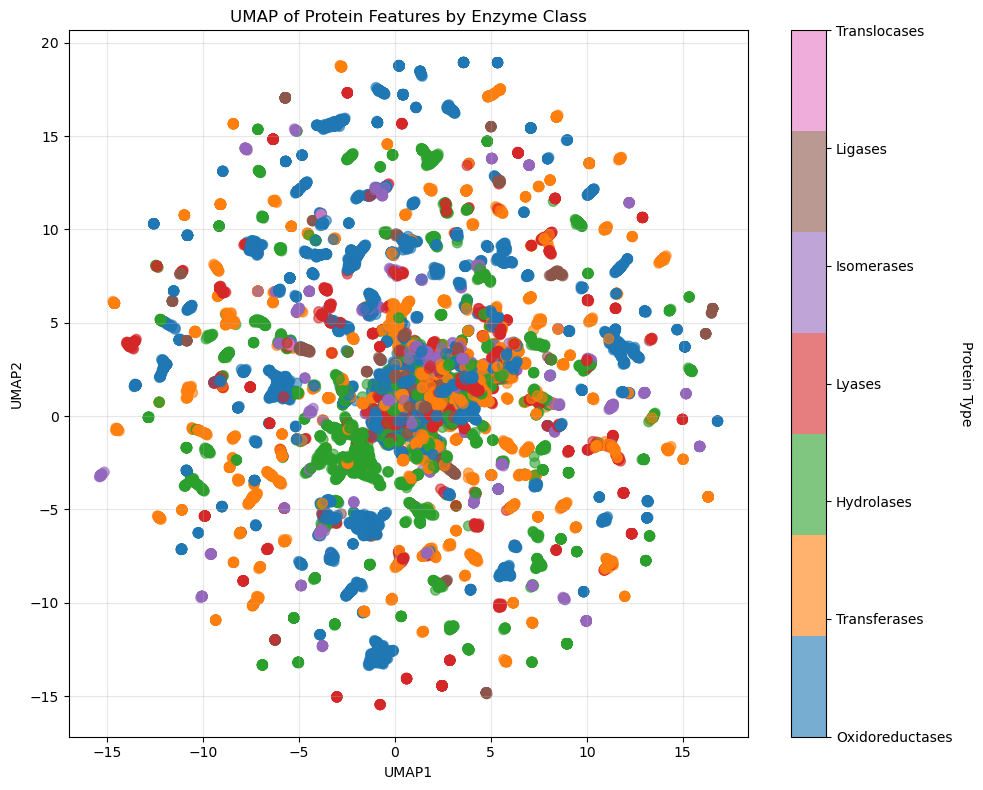

C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_29988\934284153.py:284: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(color_data) or color_data.dtype == 'object':


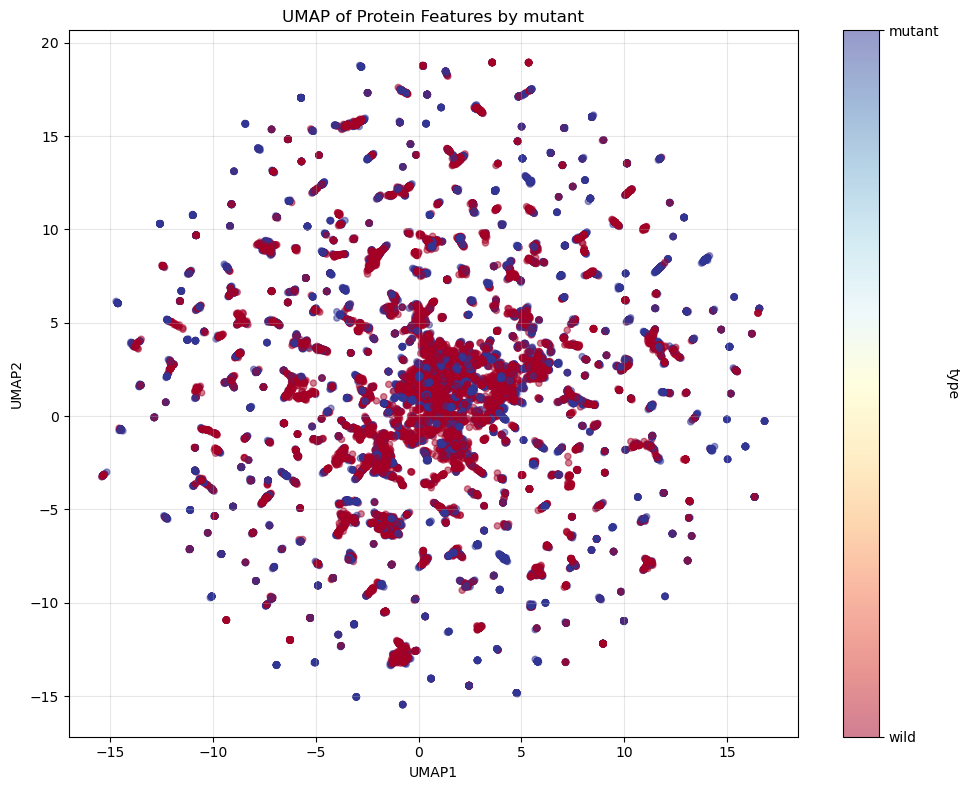

In [30]:
kcat_plotter.plot_scatter("UMAP", "protein_features", "protein_id", title="UMAP of Protein Features by Enzyme Class",save_path="./../A04_result_plot/protein_features_umap_scatter_by_protein_class.svg")
kcat_plotter.plot_scatter("UMAP", "protein_features", "type", title="UMAP of Protein Features by mutant", alpha=0.5, s=20,save_path="./../A04_result_plot/protein_features_umap_scatter_by_mutant.svg")